Base principale : Construction, Nettoyage et Stat descriptives

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import seaborn as sns



In [29]:
coureur_tdf = pd.read_csv("https://drive.google.com/file/d/1Xp9abybCL4lzRrAZrZaU69rCPFjGbBBJ/view?usp=sharing")

Nettoyage d'une première base de données (coureur_tdf) : 
    - Nom du coureur
    - Classement (par année)
    - Equipe
    - Temps
    - Année
    - Distance
    - ...

In [3]:
coureur_tdf.rename(columns={coureur_tdf.columns[2]: 'nom'}, inplace=True)
coureur_tdf['nom'] = coureur_tdf['nom'].str.title()
coureur_tdf['nom'] = coureur_tdf['nom'].str.title().str.strip()
coureur_tdf

,Unnamed: 0,Rank,nom,Rider No.,Team,Times,Gap,B,P,Year,Distance (km),Number of stages,TotalSeconds,GapSeconds,ResultType
0,0,1,Maurice Garin,1,TDF 1903 ***,94h 33' 14'',-,NaN,NaN,1903,2428,6,340394,0,time
1,1,2,Lucien Pothier,37,TDF 1903 ***,97h 32' 35'',+ 02h 59' 21'',NaN,NaN,1903,2428,6,351155,10761,time
2,2,3,Fernand Augereau,39,TDF 1903 ***,99h 02' 38'',+ 04h 29' 24'',NaN,NaN,1903,2428,6,356558,16164,time
3,3,4,Rodolphe Muller,33,TDF 1903 ***,99h 12' 44'',+ 04h 39' 30'',NaN,NaN,1903,2428,6,357164,16770,time
4,4,5,Jean-Baptiste Fischer,12,TDF 1903 ***,99h 41' 58'',+ 05h 08' 44'',NaN,NaN,1903,2428,6,358918,18524,time
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9873,9873,146,Alexander Edmondson,144,TEAM DSM - FIRMENICH,87h 50' 21'',+ 05h 44' 39'',NaN,NaN,2023,3404,21,316221,20679,time
9874,9874,147,Frederik Frison,185,LOTTO DSTNY,88h 01' 02'',+ 05h 55' 20'',NaN,NaN,2023,3404,21,316862,21320,time
9875,9875,148,Yevgeniy Fedorov,194,ASTANA QAZAQSTAN TEAM,88h 02' 19'',+ 05h 56' 37'',NaN,NaN,2023,3404,21,316939,21397,time
9876,9876,149,Cees Bol,192,ASTANA QAZAQSTAN TEAM,88h 03' 26'',+ 05h 57' 44'',NaN,NaN,2023,3404,21,317006,21464,time


Nettoyage d'une deuxième base de données (prix_coureur_tdf): 

In [32]:
prix_coureur_tdf = pd.read_csv("https://drive.google.com/file/d/1RCUw5BPznYv5xWpzNkoarlmH57z-jS3W/view?usp=drive_link")
prix_coureur_tdf.columns = ['nom', 'nbre_tdf', 'nbre_victoire_etape', 'nbre_jour_maillot_jaune']
prix_coureur_tdf

,nom,nbre_tdf,nbre_victoire_etape,nbre_jour_maillot_jaune
0,Djamolidine Abdoujaparov,8.0,0,0
1,Jean Adriaenssens,8.0,0,0
2,Mario Aerts,10.0,0,0
3,Christophe Agnolutto,5.0,1,0
4,Joaquim Agostinho,13.0,0,0
...,...,...,...,...
813,Stefano Zanini,3.0,1,0
814,Italo Zilioli,1.0,1,4
815,Urs Zimmermann,3.0,0,0
816,Joop Zoetemelk,15.0,10,22


correction des erreurs dues au scrapping

In [34]:
gagnants_etape = pd.read_csv('https://drive.google.com/file/d/1sApLsrFrpSYi0Nqoap1cnv5x4U3jjgK3/view?usp=sharing')
gagnants_etape

,Year,Stage,Winner
0,1947,1,Ferdi Kübler
1,1947,2,René Vietto
2,1947,3,Aldo Ronconi
3,1947,4,Jean Robic
4,1947,5,Ferdi Kübler
...,...,...,...
1638,2019,17,Matteo Trentin
1639,2019,18,Nairo Quintana
1640,2019,19,Pas de vainqueur
1641,2019,20,Vincenzo Nibali


In [6]:
# Charger les bases de données
db_to_correct = prix_coureur_tdf
gagnants_etape = pd.read_csv('winners.csv')

# Créer un dictionnaire des comptes de victoires de la base de données des vainqueurs
victory_counts = gagnants_etape['Winner'].value_counts().to_dict()

# Mettre à jour les victoires dans la base de données à corriger
for index, row in db_to_correct.iterrows():
    name = row['nom'] 
    correct_victories = victory_counts.get(name, 0) # Obtient le nombre de victoires du nom ou 0 si non trouvé

    if row['nbre_victoire_etape'] != correct_victories: 
        db_to_correct.at[index, 'nbre_victoire_etape'] = correct_victories # Mise à jour du nombre de victoires

db_to_correct.to_csv('palmares_tdf2.csv', index=False)
prix_coureur_tdf = pd.read_csv('palmares_tdf2.csv')
prix_coureur_tdf

,nom,nbre_tdf,nbre_victoire_etape,nbre_jour_maillot_jaune
0,Djamolidine Abdoujaparov,8.0,0,0
1,Jean Adriaenssens,8.0,0,0
2,Mario Aerts,10.0,0,0
3,Christophe Agnolutto,5.0,1,0
4,Joaquim Agostinho,13.0,0,0
...,...,...,...,...
813,Stefano Zanini,3.0,1,0
814,Italo Zilioli,1.0,1,4
815,Urs Zimmermann,3.0,0,0
816,Joop Zoetemelk,15.0,10,22


On refait pareil pour la colonne nbre_jour_maillot_jaune car certains noms composé notamment hollandais avait fait buggé le scrapping

In [7]:
maillot_jaune = pd.read_csv('https://drive.google.com/file/d/1qdlOkGcP-VQysoqWmzjMOl-BBHYmgQhO/view?usp=sharing')
maillot_jaune

,Name,Yellow Jerseys
0,Eddy Merckx,96
1,Bernard Hinault,79
2,Miguel Indurain,60
3,Christopher Froome,59
4,Jacques Anquetil,51
...,...,...
293,Fernando Gaviria,1
294,Alexander Kristoff,1
295,Yves Lampaert,1
296,Jai Hindley,1


In [8]:


# Charger les bases de données
db_to_correct = prix_coureur_tdf
correct_db = maillot_jaune

# Créer un dictionnaire des comptes de jours en maillot jaune de la base de données correcte
correct_days_yellow_jersey = correct_db.set_index('Name')['Yellow Jerseys'].to_dict()

# Mettre à jour les jours en maillot jaune dans la base de données à corriger
for index, row in db_to_correct.iterrows():
    name = row['nom']  
    correct_days = correct_days_yellow_jersey.get(name, None)  # Obtient le nombre correct de jours ou None si non trouvé

    if correct_days is not None and row['nbre_jour_maillot_jaune'] != correct_days:
        # Mise à jour du nombre de jours en maillot jaune si différent
        db_to_correct.at[index, 'nbre_jour_maillot_jaune'] = correct_days

# Enregistre les modifications dans un nouveau fichier ou écrase l'ancien si sûr
db_to_correct.to_csv('palmares_tdf2.csv', index=False)
prix_coureur_tdf

,nom,nbre_tdf,nbre_victoire_etape,nbre_jour_maillot_jaune
0,Djamolidine Abdoujaparov,8.0,0,0
1,Jean Adriaenssens,8.0,0,0
2,Mario Aerts,10.0,0,0
3,Christophe Agnolutto,5.0,1,0
4,Joaquim Agostinho,13.0,0,0
...,...,...,...,...
813,Stefano Zanini,3.0,1,0
814,Italo Zilioli,1.0,1,4
815,Urs Zimmermann,3.0,0,0
816,Joop Zoetemelk,15.0,10,22


On avait réussi à scraper les prix gagnés par certains coureurs cyclistes, et on va ensuite l'incorporer dans la grande base de donnée

In [9]:
df_maillot = pd.read_csv('https://drive.google.com/file/d/1vGDnYaDpD22VCfhsL3Vmx26QGIrZBbYl/view?usp=sharing')
df_maillot

,Grand Prix de la montagne,Par points,Meilleur jeune,Prix de la combativité,Année
0,NaN,NaN,NaN,NaN,1903
1,NaN,NaN,NaN,NaN,1904
2,NaN,NaN,NaN,NaN,1905
3,NaN,NaN,NaN,NaN,1906
4,NaN,NaN,NaN,NaN,1907
...,...,...,...,...,...
105,Romain Bardet,Peter Sagan,Egan Bernal,Julian Alaphilippe,2019
106,Tadej Pogačar,Sam Bennett,Tadej Pogačar,Marc Hirschi,2020
107,Tadej Pogačar,Mark Cavendish,Tadej Pogačar,Franck Bonnamour,2021
108,Jonas Vingegaard,Wout van Aert,Tadej Pogačar,Wout van Aert,2022


In [10]:
# Ajouter les nouvelles colonnes à coureur_tdf
for col in ['Grand Prix de la Montagne', 'Par Points', 'Meilleur Jeune', 'Prix de la Combativité']:
    coureur_tdf[col] = 0

# Remplir les nouvelles colonnes
for index, row in coureur_tdf.iterrows():
    # Obtenir l'année et le nom du coureur
    year = row['Year']
    name = row['nom']
    
    # Vérifier si le coureur a gagné un prix cette année
    # Remrque: on a binariser les colonnes Grand Prix, par points,Meilleur jeune et prix de la combativité
    prix_row = df_maillot[df_maillot['Année'] == year]
    if not prix_row.empty:
        if name == prix_row['Grand Prix de la montagne'].values[0]:
            coureur_tdf.at[index, 'Grand Prix de la Montagne'] = 1
        if name == prix_row['Par points'].values[0]:
            coureur_tdf.at[index, 'Par Points'] = 1
        if name == prix_row['Meilleur jeune'].values[0]:
            coureur_tdf.at[index, 'Meilleur Jeune'] = 1
        if name == prix_row['Prix de la combativité'].values[0]:
            coureur_tdf.at[index, 'Prix de la Combativité'] = 1
coureur_tdf

,Unnamed: 0,Rank,nom,Rider No.,Team,Times,Gap,B,P,Year,Distance (km),Number of stages,TotalSeconds,GapSeconds,ResultType,Grand Prix de la Montagne,Par Points,Meilleur Jeune,Prix de la Combativité
0,0,1,Maurice Garin,1,TDF 1903 ***,94h 33' 14'',-,NaN,NaN,1903,2428,6,340394,0,time,0,0,0,0
1,1,2,Lucien Pothier,37,TDF 1903 ***,97h 32' 35'',+ 02h 59' 21'',NaN,NaN,1903,2428,6,351155,10761,time,0,0,0,0
2,2,3,Fernand Augereau,39,TDF 1903 ***,99h 02' 38'',+ 04h 29' 24'',NaN,NaN,1903,2428,6,356558,16164,time,0,0,0,0
3,3,4,Rodolphe Muller,33,TDF 1903 ***,99h 12' 44'',+ 04h 39' 30'',NaN,NaN,1903,2428,6,357164,16770,time,0,0,0,0
4,4,5,Jean-Baptiste Fischer,12,TDF 1903 ***,99h 41' 58'',+ 05h 08' 44'',NaN,NaN,1903,2428,6,358918,18524,time,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9873,9873,146,Alexander Edmondson,144,TEAM DSM - FIRMENICH,87h 50' 21'',+ 05h 44' 39'',NaN,NaN,2023,3404,21,316221,20679,time,0,0,0,0
9874,9874,147,Frederik Frison,185,LOTTO DSTNY,88h 01' 02'',+ 05h 55' 20'',NaN,NaN,2023,3404,21,316862,21320,time,0,0,0,0
9875,9875,148,Yevgeniy Fedorov,194,ASTANA QAZAQSTAN TEAM,88h 02' 19'',+ 05h 56' 37'',NaN,NaN,2023,3404,21,316939,21397,time,0,0,0,0
9876,9876,149,Cees Bol,192,ASTANA QAZAQSTAN TEAM,88h 03' 26'',+ 05h 57' 44'',NaN,NaN,2023,3404,21,317006,21464,time,0,0,0,0


Fusion avec la première base de données et nettoyage du résultat : 

In [11]:
# Compter les occurrences dans la deuxième base de données
comptage = coureur_tdf.groupby('nom').size().reset_index(name='comptage_unique')

# Vérifier si 'comptage_unique' existe déjà dans prix_coureur_tdf, si oui, le supprimer
if 'comptage_unique' in prix_coureur_tdf.columns:
    prix_coureur_tdf.drop('comptage_unique', axis=1, inplace=True)

# Fusionner avec la première base de données
prix_coureur_tdf = pd.merge(prix_coureur_tdf, comptage, on='nom', how='left')

# Mettre à jour la colonne 'nbre_tdf' là où elle vaut 0
prix_coureur_tdf.loc[prix_coureur_tdf['nbre_tdf'] == 0, 'nbre_tdf'] = prix_coureur_tdf['comptage_unique']

# Supprimer la colonne 'comptage_unique' car elle n'est plus nécessaire
prix_coureur_tdf.drop('comptage_unique', axis=1, inplace=True)
prix_coureur_tdf = prix_coureur_tdf.dropna()
prix_coureur_tdf

,nom,nbre_tdf,nbre_victoire_etape,nbre_jour_maillot_jaune
0,Djamolidine Abdoujaparov,8.0,0,0
1,Jean Adriaenssens,8.0,0,0
2,Mario Aerts,10.0,0,0
3,Christophe Agnolutto,5.0,1,0
4,Joaquim Agostinho,13.0,0,0
...,...,...,...,...
813,Stefano Zanini,3.0,1,0
814,Italo Zilioli,1.0,1,4
815,Urs Zimmermann,3.0,0,0
816,Joop Zoetemelk,15.0,10,22


Fusion des DataFrames pour obtenir une base complète finale (merged_df) et nettoyage : 

In [12]:
# Fusion des DataFrames sur la colonne 'Stage_Key'
merged_df = pd.merge(prix_coureur_tdf, coureur_tdf, on='nom', how='inner')
merged_df = merged_df.dropna(axis=1, how='all')
# Suppression des colonnes inutiles
merged_df = merged_df.drop(['B', 'P', 'Unnamed: 0', 'Rider No.','Times','GapSeconds','Gap'], axis=1)

# Affichage des premières lignes du DataFrame fusionné pour vérification
merged_df

,nom,nbre_tdf,nbre_victoire_etape,nbre_jour_maillot_jaune,Rank,Team,Year,Distance (km),Number of stages,TotalSeconds,ResultType,Grand Prix de la Montagne,Par Points,Meilleur Jeune,Prix de la Combativité
0,Djamolidine Abdoujaparov,8.0,0,0,145,ALFA LUM,1990,3504,22,335768,time,0,0,0,0
1,Djamolidine Abdoujaparov,8.0,0,0,85,CARRERA JEANS,1991,3914,23,370225,time,0,1,0,0
2,Djamolidine Abdoujaparov,8.0,0,0,76,LAMPRE-POLTI,1993,3714,21,352842,time,0,1,0,0
3,Djamolidine Abdoujaparov,8.0,0,0,57,TEAM POLTI,1994,3978,22,379812,time,0,1,0,0
4,Djamolidine Abdoujaparov,8.0,0,0,56,NOVELL,1995,3635,21,341634,time,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3366,Haimar Zubeldia,15.0,0,0,36,RADIOSHACK LEOPARD,2013,3404,21,307262,time,0,0,0,0
3367,Haimar Zubeldia,15.0,0,0,8,TREK FACTORY RACING,2014,3659,21,325023,time,0,0,0,0
3368,Haimar Zubeldia,15.0,0,0,62,TREK FACTORY RACING,2015,3354,21,314584,time,0,0,0,0
3369,Haimar Zubeldia,15.0,0,0,24,TREK - SEGAFREDO,2016,3525,21,323874,time,0,0,0,0


Création d'une colonne classement : 

In [13]:

#Étape 1 : Grouper par équipe et année, puis obtenir les trois plus faibles temps



temps_par_equipe = merged_df.groupby(['Year', 'Team'])['TotalSeconds'].nsmallest(3).groupby(level=[0, 1]).sum()

# Étape 2 : Convertir la série groupée en DataFrame et réinitialiser l'index
temps_par_equipe = temps_par_equipe.reset_index()

# Étape 3 : Trier les équipes pour chaque année par leur temps total et obtenir le classement
temps_par_equipe['classement'] = temps_par_equipe.groupby('Year')['TotalSeconds'].rank(method='min')

# Étape 4 : Fusionner le classement avec le DataFrame original
df = pd.merge(merged_df, temps_par_equipe, on=['Year', 'Team'], how='left')
df_trie = df.sort_values(by='Year', ascending=True)
df_trie

,nom,nbre_tdf,nbre_victoire_etape,nbre_jour_maillot_jaune,Rank,Team,Year,Distance (km),Number of stages,TotalSeconds_x,ResultType,Grand Prix de la Montagne,Par Points,Meilleur Jeune,Prix de la Combativité,TotalSeconds_y,classement
1781,Ludo Loos,3.0,1,0,20,TDF 1905 ***,1905,2994,11,0,NaN,0,0,0,0,0,1.0
2499,Pascal Richard,6.0,2,0,44,TOURISTES ROUTIERS,1924,5425,15,913722,time,0,0,0,0,913722,1.0
3142,René Vietto,3.0,2,26,5,FRANCE,1934,4470,24,533580,time,1,0,0,0,533580,1.0
3143,René Vietto,3.0,2,26,8,FRANCE,1935,4338,27,514383,time,0,0,0,0,514383,1.0
412,Albert Bourlon,2.0,1,0,35,BLEUETS,1938,4694,29,542832,time,0,0,0,0,542832,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2894,Mike Teunissen,4.0,1,2,103,INTERMARCHÉ - CIRCUS - WANTY,2023,3404,21,312437,time,0,0,0,0,622482,10.0
299,Tiesj Benoot,7.0,0,0,24,JUMBO-VISMA,2023,3404,21,301957,time,0,0,0,0,895293,11.0
695,Magnus Cort Nielsen,5.0,1,0,96,EF EDUCATION - EASYPOST,2023,3404,21,311877,time,0,0,0,0,621234,9.0
2374,Thibaut Pinot,10.0,3,0,11,GROUPAMA - FDJ,2023,3404,21,297225,time,0,0,0,0,904068,13.0


Pour le modèle de prédiction, on va créer une fonction qui prend en entrée un rang et qui redonne un nombre entre 0 et 1 avec 1 étant le moins bon rang, pour faciliter la prédiction du modèle.

In [14]:
# Fonction pour normaliser le classement des joueurs
def normalize_ranking(row, max_rank):
    return (max_rank - row) / (max_rank - 1)

# Appliquer la fonction à la colonne de classement
max_rank = df_trie['Rank'].max()  # On cherche le rank le plus bas (nombre le plus grand)
df_trie['normalized_ranking'] = df_trie['Rank'].apply(lambda x: normalize_ranking(x, max_rank))
# On supprime ensuite la colonne Rank
df_trie = df_trie.drop(['TotalSeconds_y','Rank'], axis=1)
df_trie

,nom,nbre_tdf,nbre_victoire_etape,nbre_jour_maillot_jaune,Team,Year,Distance (km),Number of stages,TotalSeconds_x,ResultType,Grand Prix de la Montagne,Par Points,Meilleur Jeune,Prix de la Combativité,classement,normalized_ranking
1781,Ludo Loos,3.0,1,0,TDF 1905 ***,1905,2994,11,0,NaN,0,0,0,0,1.0,0.890173
2499,Pascal Richard,6.0,2,0,TOURISTES ROUTIERS,1924,5425,15,913722,time,0,0,0,0,1.0,0.751445
3142,René Vietto,3.0,2,26,FRANCE,1934,4470,24,533580,time,1,0,0,0,1.0,0.976879
3143,René Vietto,3.0,2,26,FRANCE,1935,4338,27,514383,time,0,0,0,0,1.0,0.959538
412,Albert Bourlon,2.0,1,0,BLEUETS,1938,4694,29,542832,time,0,0,0,0,2.0,0.803468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2894,Mike Teunissen,4.0,1,2,INTERMARCHÉ - CIRCUS - WANTY,2023,3404,21,312437,time,0,0,0,0,10.0,0.410405
299,Tiesj Benoot,7.0,0,0,JUMBO-VISMA,2023,3404,21,301957,time,0,0,0,0,11.0,0.867052
695,Magnus Cort Nielsen,5.0,1,0,EF EDUCATION - EASYPOST,2023,3404,21,311877,time,0,0,0,0,9.0,0.450867
2374,Thibaut Pinot,10.0,3,0,GROUPAMA - FDJ,2023,3404,21,297225,time,0,0,0,0,13.0,0.942197


Sauvegarde de la base de donnée finale : 

In [15]:
df_trie.to_csv('merged_database.csv', index=False)

In [16]:
print(df_trie.columns)

Index(['nom', 'nbre_tdf', 'nbre_victoire_etape', 'nbre_jour_maillot_jaune',
       'Team', 'Year', 'Distance (km)', 'Number of stages', 'TotalSeconds_x',
       'ResultType', 'Grand Prix de la Montagne', 'Par Points',
       'Meilleur Jeune', 'Prix de la Combativité', 'classement',
       'normalized_ranking'],
      dtype='object')


test de différents modèles prédictifs pour le rang des différents coureurs cyclistes

In [17]:

def train_and_test(X: pd.DataFrame, y):
    """
    Train and test on provided inputs.
    """
    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initializing models
    models = {
        'Linear Regression': LinearRegression(),
        'Support Vector Regression': SVR(),
        'Decision Tree Regressor': DecisionTreeRegressor(),
        'Random Forest Regressor': RandomForestRegressor(),
        'Gradient Boosting Regressor': GradientBoostingRegressor()
    }

    # Training and evaluating models
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

    # Training and evaluating models with additional metrics
    scores = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        mse = mean_squared_error(y_test, predictions)
        mae = mean_absolute_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        scores[name] = {'MSE': mse, 'MAE': mae, 'R²': r2}

    # Printing scores for each model
    for name, metrics in scores.items():
        print(f"{name} - MSE: {metrics['MSE']}, MAE: {metrics['MAE']}, R²: {metrics['R²']}")

In [18]:
features_col_names = ['nbre_tdf',	'nbre_victoire_etape',	'nbre_jour_maillot_jaune',	'Distance (km)',	'Number of stages',	'TotalSeconds_x',	'Grand Prix de la Montagne',	'Par Points',	'Meilleur Jeune',	'Prix de la Combativité']

# Séparez le DataFrame en une matrice de features (X) et une colonne de labels (y)
X = df_trie[features_col_names]  # Matrice de features (X)
y = df_trie['normalized_ranking']         # Colonne de labels (y)~

train_and_test(X, y)

Linear Regression - MSE: 0.03973569654999726, MAE: 0.16202132361809948, R²: 0.17171510975496806
Support Vector Regression - MSE: 0.04504326105894965, MAE: 0.17417384789458912, R²: 0.061079689504197066
Decision Tree Regressor - MSE: 0.005075468732791062, MAE: 0.03403982016698779, R²: 0.8942025828843253
Random Forest Regressor - MSE: 0.003120047440671319, MAE: 0.037753286234211085, R²: 0.9349630590040352
Gradient Boosting Regressor - MSE: 0.021219665688474845, MAE: 0.11506810622076138, R²: 0.557679114956502


Interprétation des résultats

In [23]:

scores = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    scores[name] = {'MSE': mse, 'MAE': mae, 'R²': r2}


# Trouver le modèle avec le plus faible MSE
best_model_mse = min(scores, key=lambda k: scores[k]['MSE'])
best_mse_score = scores[best_model_mse]['MSE']

# Trouver le modèle avec le plus faible MAE
best_model_mae = min(scores, key=lambda k: scores[k]['MAE'])
best_mae_score = scores[best_model_mae]['MAE']

# Trouver le modèle avec le plus haut R²
best_model_r2 = max(scores, key=lambda k: scores[k]['R²'])
best_r2_score = scores[best_model_r2]['R²']

# Afficher les meilleurs modèles et leurs scores
print(f"Best Model by MSE: {best_model_mse} with MSE: {best_mse_score}")
print(f"Best Model by MAE: {best_model_mae} with MAE: {best_mae_score}")
print(f"Best Model by R²: {best_model_r2} with R²: {best_r2_score}")

Linear Regression - MSE: 22.64715912856764, MAE: 3.8688427613203653, R²: 0.10948569522935725
Support Vector Regression - MSE: 22.276837539713004, MAE: 3.8610213000084896, R²: 0.124047198081362
Decision Tree Regressor - MSE: 37.895185185185184, MAE: 4.797777777777778, R²: -0.49008554661373505
Random Forest Regressor - MSE: 24.86218362687243, MAE: 3.977926172839506, R²: 0.022388192626054404
Gradient Boosting Regressor - MSE: 21.02011296816145, MAE: 3.7133122614024225, R²: 0.1734631624312446
Best Model by MSE: Gradient Boosting Regressor with MSE: 21.02011296816145
Best Model by MAE: Gradient Boosting Regressor with MAE: 3.7133122614024225
Best Model by R²: Gradient Boosting Regressor with R²: 0.1734631624312446


Modèle prédictif sur le classement des équipes

création d'un nouveau dataframe où chaque ligne correspond à une équipe par année

In [19]:
# Grouping the data by team and year and calculating the required statistics
grouped = df_trie.groupby(['Team', 'Year'])

# Calculating the required statistics for each team per year
team_stats = grouped.agg({
    'nbre_tdf': ['min', 'mean', 'max'],
    'nbre_jour_maillot_jaune': 'sum',
    'classement': ['mean'],
    'Number of stages': 'mean',
    'TotalSeconds_x': ['min','max','mean', 'sum'],
    'Grand Prix de la Montagne': 'sum',
    'Par Points': 'sum',
    'Meilleur Jeune': 'sum',
    'Prix de la Combativité': 'sum'
})

# Resetting index to make 'Team' and 'Year' columns instead of index
team_stats = team_stats.reset_index()

team_stats

Team  Year nbre_tdf                   \
                                                       min       mean   max   
0                           A.D.R. - I.O.C.  1988      1.0   6.000000   9.0   
1     ACBB-SAINT RAPHAEL-HELYETT-HUTCHINSON  1962      4.0   7.600000  12.0   
2                    ADR-AGRIGEL-BOTTECCHIA  1989      9.0  10.000000  11.0   
3                AERNOUDT-HOONVED-ZEEP MARC  1983      7.0   7.000000   7.0   
4                         AG2R CITROEN TEAM  2021      2.0   5.500000   9.0   
...                                     ...   ...      ...        ...   ...   
1185                              Z-PEUGEOT  1990      8.0   8.000000   8.0   
1186                 ZG MOBILI-SELLE ITALIA  1994      3.0   7.833333  12.0   
1187                         ZG MOBILI-SIDI  1993      3.0   4.333333   6.0   
1188                                    ZOR  1985      7.0   7.000000   7.0   
1189                                 ZOR-BH  1986      7.0   7.000000   7.0   

     nbre_jour_maillot_jaune classement Number of stages TotalSeconds_x  \
                         sum       mean             mean            min   
0                          0       21.0             23.0         311847   
1                         70       13.0             24.0         412314   
2                          5        7.0             22.0         322795   
3                          0        4.0             23.0         389078   
4                         11       10.0             21.0         299198   
...                      ...        ...              ...            ...   
1185                       2       10.0             22.0         327929   
1186                       9       16.0             22.0         375236   
1187                       0       16.0             21.0         349044   
1188                       0        3.0             24.0         416205   
1189                       0        4.0             24.0         402452   

                                     Grand Prix de la Montagne Par Points  \
         max           mean      sum                       sum        sum   
0     312765  312338.333333   937015                         0          1   
1     418244  415497.000000  2077485                         0          1   
2     323546  323170.500000   646341                         0          0   
3     389078  389078.000000   389078                         0          0   
4     310865  305031.500000   610063                         0          0   
...      ...            ...      ...                       ...        ...   
1185  331554  328925.000000  1315700                         0          0   
1186  382410  379541.833333  2277251                         0          0   
1187  354082  351661.000000  1054983                         0          0   
1188  416205  416205.000000   416205                         0          0   
1189  402452  402452.000000   402452                         0          0   

     Meilleur Jeune Prix de la Combativité  
                sum                    sum  
0                 0                      0  
1                 0                      0  
2                 0                      0  
3                 0                      0  
4                 0                      0  
...             ...                    ...  
1185              0                      0  
1186              0                      0  
1187              0                      1  
1188              0                      0  
1189              0                      0  

[1190 rows x 16 columns]

In [20]:
features_col_names = ['nbre_tdf',	'nbre_jour_maillot_jaune',	'Number of stages',	'TotalSeconds_x',	'Grand Prix de la Montagne',	'Par Points',	'Meilleur Jeune',	'Prix de la Combativité']

# Séparez le DataFrame en une matrice de features (X) et une colonne de labels (y)
X_equipe = df_trie[features_col_names]  # Matrice de features (X)
y_equipe = df_trie['classement']         # Colonne de labels (y)~

train_and_test(X_equipe, y_equipe)

Linear Regression - MSE: 22.629351145498045, MAE: 3.864664218328264, R²: 0.11018592714685993
Support Vector Regression - MSE: 22.2770780893605, MAE: 3.8610298688873486, R²: 0.12403773937173368
Decision Tree Regressor - MSE: 39.79148148148148, MAE: 4.901481481481482, R²: -0.5646502621415781
Random Forest Regressor - MSE: 24.186335979218107, MAE: 3.944103950617284, R²: 0.04896335795540352
Gradient Boosting Regressor - MSE: 20.576676605513498, MAE: 3.6854975257207427, R²: 0.19089962861014576


In [21]:
scores = train_and_test(X_equipe, y_equipe)
# Trouver le modèle avec le plus faible MSE
best_model_mse = min(scores, key=lambda k: scores[k]['MSE'])
best_mse_score = scores[best_model_mse]['MSE']

# Trouver le modèle avec le plus faible MAE
best_model_mae = min(scores, key=lambda k: scores[k]['MAE'])
best_mae_score = scores[best_model_mae]['MAE']

# Trouver le modèle avec le plus haut R²
best_model_r2 = max(scores, key=lambda k: scores[k]['R²'])
best_r2_score = scores[best_model_r2]['R²']

# Afficher les meilleurs modèles et leurs scores
print(f"Best Model by MSE: {best_model_mse} with MSE: {best_mse_score}")
print(f"Best Model by MAE: {best_model_mae} with MAE: {best_mae_score}")
print(f"Best Model by R²: {best_model_r2} with R²: {best_r2_score}")

Linear Regression - MSE: 22.629351145498045, MAE: 3.864664218328264, R²: 0.11018592714685993
Support Vector Regression - MSE: 22.2770780893605, MAE: 3.8610298688873486, R²: 0.12403773937173368
Decision Tree Regressor - MSE: 38.723333333333336, MAE: 4.822962962962963, R²: -0.5226493559731602
Random Forest Regressor - MSE: 23.733685994156378, MAE: 3.8840745679012345, R²: 0.06676211516213948
Gradient Boosting Regressor - MSE: 20.576047352995346, MAE: 3.6857485107367607, R²: 0.19092437159735876


TypeError: 'NoneType' object is not iterable

Statistiques descriptives : 

In [22]:
merged_df.describe()

,nbre_tdf,nbre_victoire_etape,nbre_jour_maillot_jaune,Rank,Year,Distance (km),Number of stages,TotalSeconds,Grand Prix de la Montagne,Par Points,Meilleur Jeune,Prix de la Combativité
count,3371.000000,3371.000000,3371.000000,3371.000000,3371.000000,3371.000000,3371.000000,3371.000000,3371.000000,3371.000000,3371.000000,3371.000000
mean,7.809255,2.157520,2.474933,51.064076,1989.794126,3835.120439,22.658558,371919.769801,0.017799,0.018392,0.008009,0.014536
std,3.317535,3.586463,8.140689,39.158182,20.944516,417.361371,1.974917,64581.881577,0.132239,0.134385,0.089150,0.119703
min,1.000000,0.000000,0.000000,1.000000,1905.000000,2994.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,0.000000,0.000000,18.000000,1974.000000,3497.000000,21.000000,319284.500000,0.000000,0.000000,0.000000,0.000000
50%,8.000000,1.000000,0.000000,43.000000,1991.000000,3753.000000,22.000000,345537.000000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,2.000000,1.000000,76.000000,2008.000000,4109.000000,24.000000,417282.000000,0.000000,0.000000,0.000000,0.000000
max,18.000000,34.000000,96.000000,174.000000,2023.000000,5425.000000,29.000000,913722.000000,1.000000,1.000000,1.000000,1.000000


In [23]:
# Sélectionner uniquement les colonnes numériques
colonnes_numeriques = merged_df.select_dtypes(include='number')

# Filtrer les données où 'Year' est supérieur à 1980 (on peut décider d'autres dâtes)
colonnes_numeriques = colonnes_numeriques[colonnes_numeriques['Year'] > 1946]

# Grouper par année
grouped_by_year = colonnes_numeriques.groupby('Year')

# Calculer la moyenne par colonne pour chaque groupe
mean_by_column = grouped_by_year.mean()

# Afficher la moyenne par colonne
# print(mean_by_column)

groupe_1948 = grouped_by_year.get_group(1948)
print(groupe_1948)

      nbre_tdf  nbre_victoire_etape  nbre_jour_maillot_jaune  Rank  Year  \
227        6.0                    9                       20     1  1948   
357       10.0                   11                       34     4  1948   
512        3.0                    2                        0     8  1948   
688        6.0                    3                        0    29  1948   
1138       8.0                    1                        7    24  1948   
1445       8.0                    3                        0    10  1948   
1671       3.0                    2                        3     7  1948   
2189       8.0                    3                        0    11  1948   
2519      10.0                    6                        2    16  1948   
2884       8.0                    4                        0     6  1948   
3146       3.0                    2                       26    17  1948   

      Distance (km)  Number of stages  TotalSeconds  \
227            4922             

Base de données par coureur depuis 2010 pour voir les performances individuelles : 

In [24]:
# Supposez que votre DataFrame initial soit 'df'

# Convertir la colonne 'Year' en type datetime avec seulement l'année
df['Year'] = pd.to_datetime(df['Year'], format='%Y')

# Filtrer les données pour les années à partir de 1980
df_since_2010 = df[df['Year'].dt.year >= 2010]

# Groupement par coureur
grouped_by_rider_since_2010 = df_since_2010.groupby('nom')

# Calcul des statistiques descriptives
average_rank_since_2010 = grouped_by_rider_since_2010['classement'].mean()
participation_count_since_2010 = grouped_by_rider_since_2010['Year'].count()
variance_performance_since_2010 = grouped_by_rider_since_2010['classement'].var()

# Création d'un nouveau DataFrame avec les données agrégées
aggregated_data_since_2010 = pd.DataFrame({
    'Moyenne_Classement': average_rank_since_2010,
    'Nombre_Participations': participation_count_since_2010,
    'Variance_Classement': variance_performance_since_2010
})

# Réinitialisation de l'index pour faire de 'nom' une colonne plutôt qu'un index
aggregated_data_since_2010.reset_index(inplace=True)

# Affichage du nouveau DataFrame
# print(aggregated_data_since_2010)


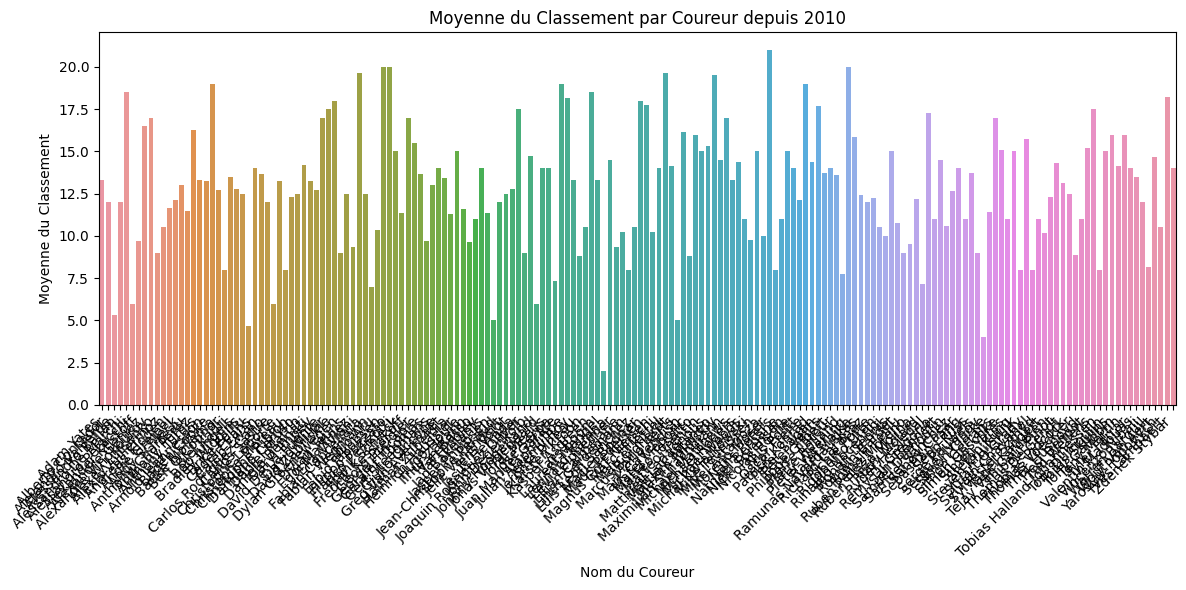

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Tracer un graphique en barres pour la moyenne du classement depuis 1980
plt.figure(figsize=(12, 6))
sns.barplot(x='nom', y='Moyenne_Classement', data=aggregated_data_since_2010)
plt.title('Moyenne du Classement par Coureur depuis 2010')
plt.xlabel('Nom du Coureur')
plt.ylabel('Moyenne du Classement')
plt.xticks(rotation=45, ha='right')  # Rotation des noms de coureurs pour une meilleure lisibilité
plt.tight_layout()

# Afficher le graphique
plt.show()


Graphiques des stats depuis 2010 : 

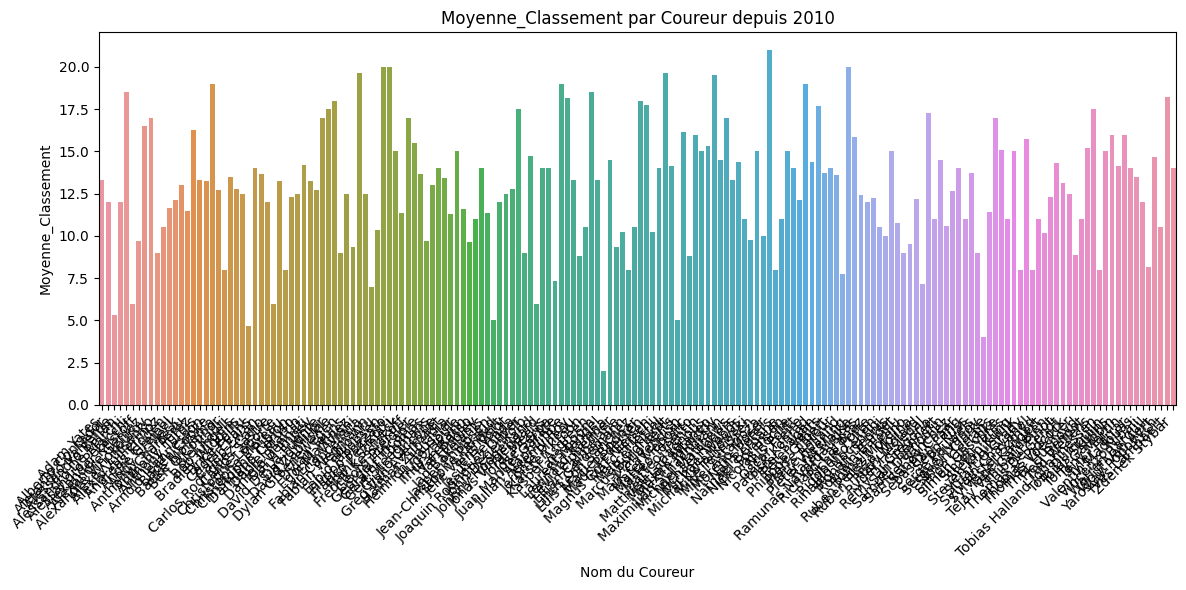

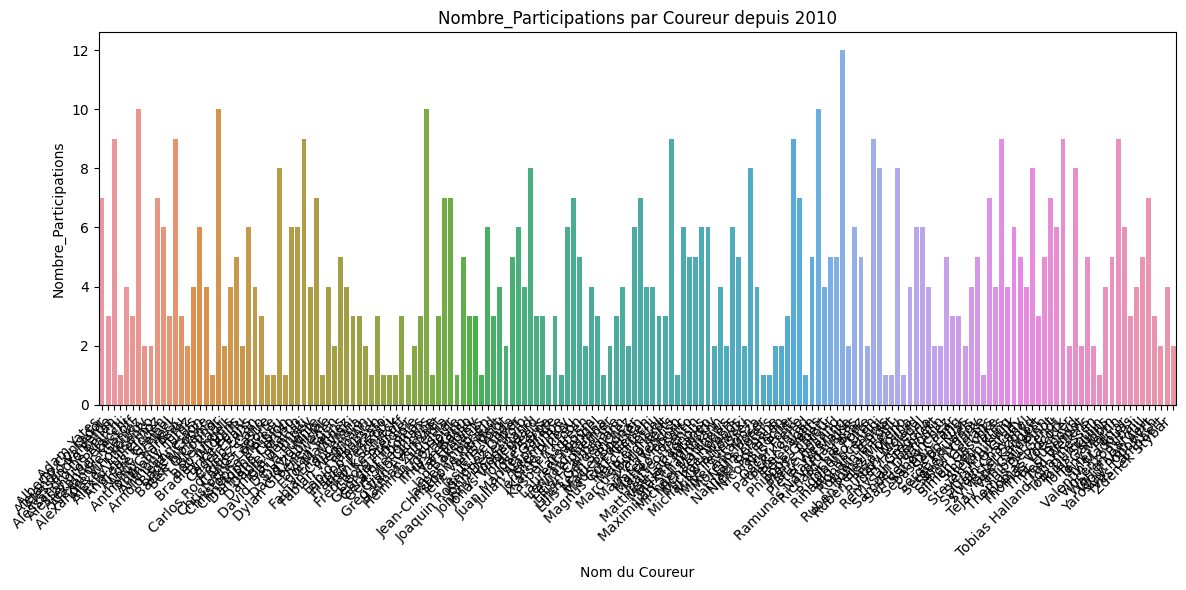

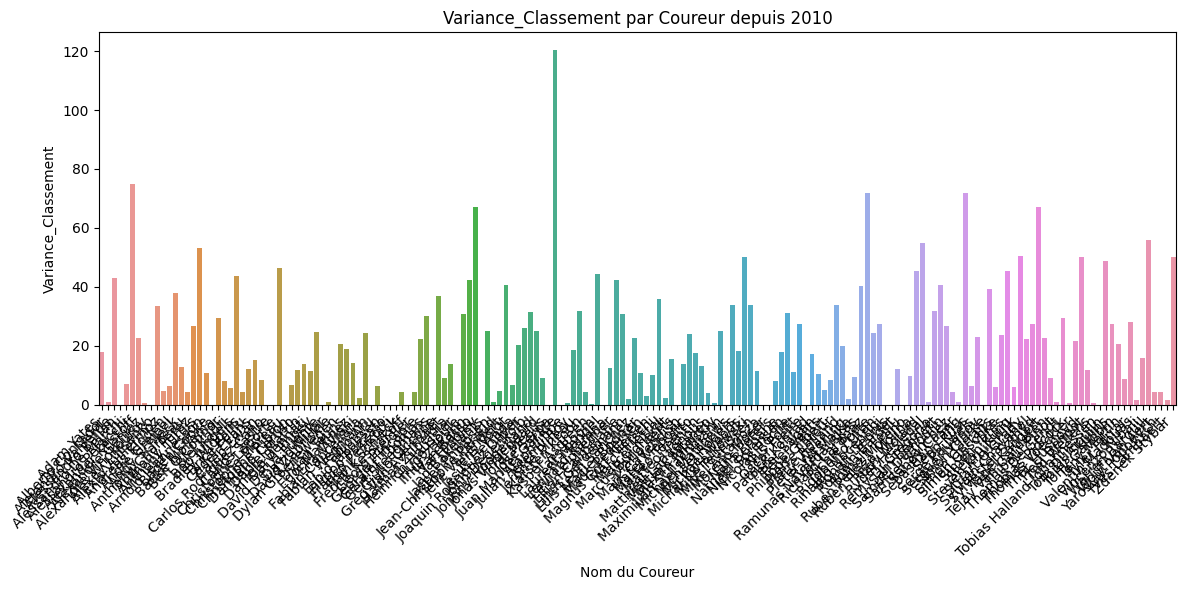

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Liste des statistiques à visualiser
statistiques = ['Moyenne_Classement', 'Nombre_Participations', 'Variance_Classement']

# Boucle pour créer un graphique pour chaque statistique
for stat in statistiques:
    plt.figure(figsize=(12, 6))
    sns.barplot(x='nom', y=stat, data=aggregated_data_since_2010)
    plt.title(f'{stat} par Coureur depuis 2010')
    plt.xlabel('Nom du Coureur')
    plt.ylabel(stat)
    plt.xticks(rotation=45, ha='right')  # Rotation des noms de coureurs pour une meilleure lisibilité
    plt.tight_layout()

# Afficher les graphiques
plt.show()


Base de données par coureur depuis 1980 pour voir les performances individuelles : 

In [27]:
# Supposez que votre DataFrame initial soit 'df'

# Filtrer les données pour les années à partir de 1980
df_since_1980 = df[df['Year'].dt.year >= 1980]

# Groupement par coureur
grouped_by_rider_since_1980 = df_since_1980.groupby('nom')

# Calcul des statistiques descriptives
average_rank_since_1980 = grouped_by_rider_since_1980['classement'].mean()
participation_count_since_1980 = grouped_by_rider_since_1980['Year'].count()
variance_performance_since_1980 = grouped_by_rider_since_1980['classement'].var()

# Création d'un nouveau DataFrame avec les données agrégées
aggregated_data_since_1980 = pd.DataFrame({
    'Moyenne_Classement': average_rank_since_1980,
    'Nombre_Participations': participation_count_since_1980,
    'Variance_Classement': variance_performance_since_1980
})

# Réinitialisation de l'index pour faire de 'nom' une colonne plutôt qu'un index
aggregated_data_since_1980.reset_index(inplace=True)


Effet du nombre de participation sur le classement moyen

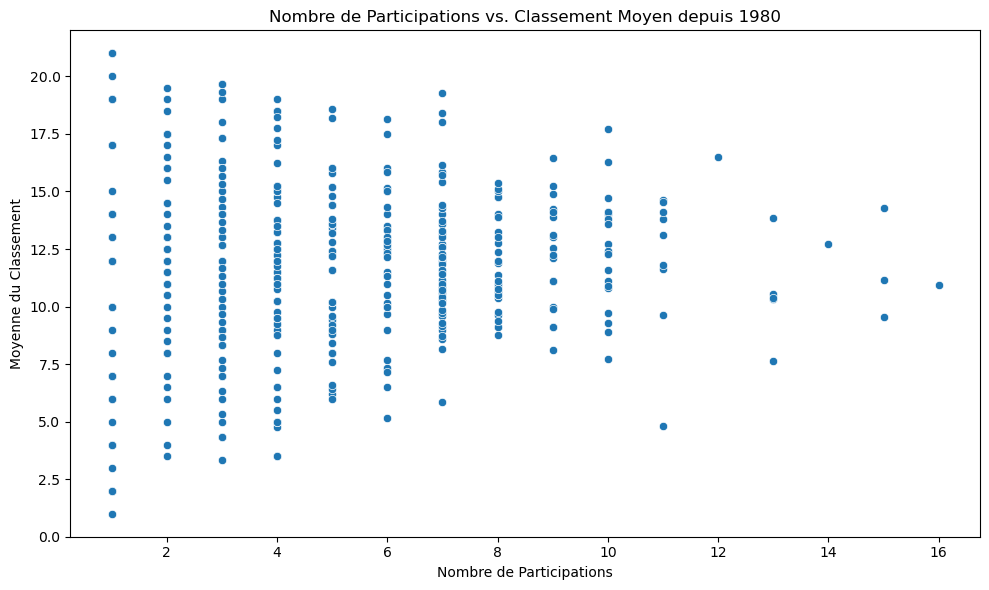

In [88]:
# Tracer un nuage de points pour le nombre de participations vs. le classement moyen
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Nombre_Participations', y='Moyenne_Classement', data=aggregated_data_since_1980)
plt.title('Nombre de Participations vs. Classement Moyen depuis 1980')
plt.xlabel('Nombre de Participations')
plt.ylabel('Moyenne du Classement')
plt.tight_layout()

# Afficher le nuage de points
plt.show()


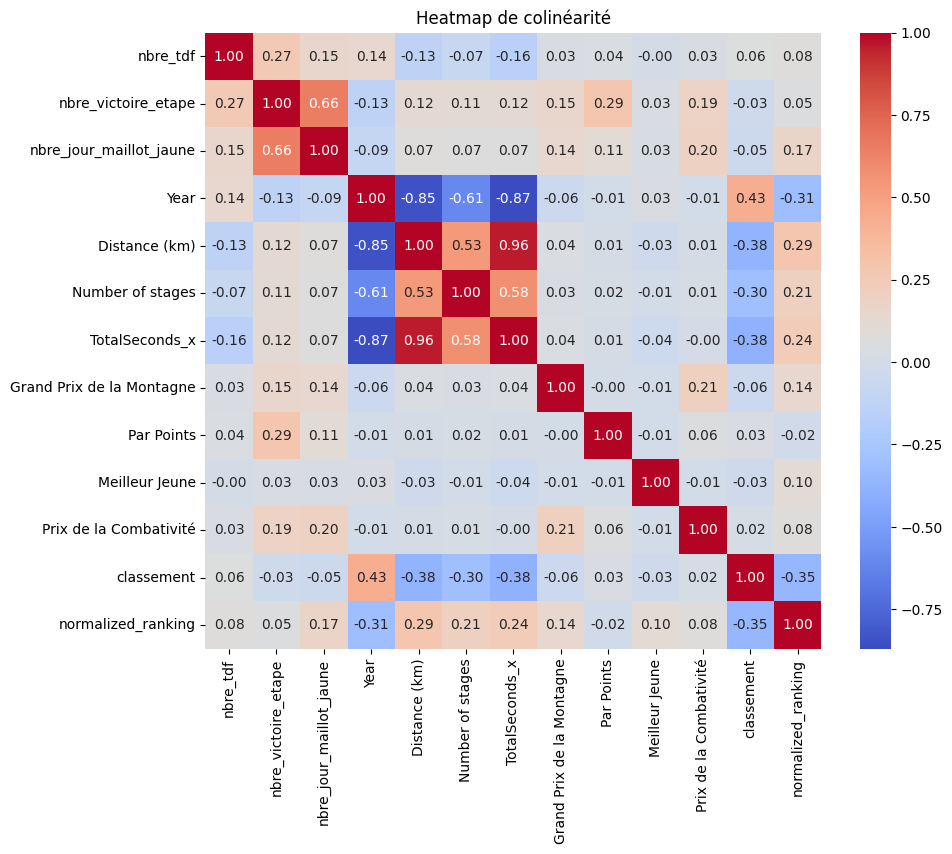

In [28]:
corr_matrix = df_trie.corr()

# Utiliser seaborn pour créer une heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)

plt.title("Heatmap de colinéarité")
plt.show()